In [9]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from softmax import SoftmaxModel
import collections
from scipy.ndimage import gaussian_filter, convolve
import time
from dataloaders import train_dataloader, test_dataloader
from torch import nn, optim
from scipy.ndimage import gaussian_filter, convolve
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssm
from utils import classes, c_to_i, get_orig, show_images

In [10]:
TRAIN_DIR = './data/processed/train/'
TEST_DIR = './data/processed/test/'

classes = os.listdir(TRAIN_DIR)
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92) / 2 + .5, cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train =test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir(TRAIN_DIR):
    for faces in os.listdir(TRAIN_DIR+c):
        img = np.array(Image.open(TRAIN_DIR+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir(TEST_DIR):
    for faces in os.listdir(TEST_DIR+c):
        img = np.array(Image.open(TEST_DIR+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

### Models

In [11]:
class SoftMax(nn.Module):

    def __init__(self):
        super(SoftMax, self).__init__()
        self.name = "SoftMax"
        self.linear1 = nn.Linear(10304, 40)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        return x

In [12]:
def buildModel(model, lRate, plot=False, verbose=False):

    startTime = time.time()
    timeStr = time.strftime("%H:%M:%S", time.localtime(startTime))
    print("Starting at " + timeStr + " to build " + model.name + " model...")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lRate)
    train_losses, validate_losses, accuracy_data = [], [], []
    valid_loss_min = np.Inf
    
    best_accuracy = 0
    iteration_count = 0
    total_iteration = 0
    
    # as in the paper, if there is no improvment after 100 iterations
    # stop training
    while iteration_count < 100:
        total_iteration += 1
        if (total_iteration%100==0): print("epoch: " + str(total_iteration))
        running_loss = 0
        for images, labels in train_dataloader:
            output = model(images)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # epoch over
        iteration_count +=1
        
        validate_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_dataloader:
                samples = model(images)
                pred = samples.argmax(dim=1)
                accuracy = (pred == labels).sum().item() / len(labels)
                
            model.train()
            train_loss = running_loss / len(train_dataloader)
            train_losses.append(train_loss)
            accuracy_data.append(accuracy)
            
            
            if accuracy > best_accuracy:  # if we improve our accuracy, set the iteration count to 0
                if verbose:
                    print("Epoch: {}.. ".format(total_iteration))
                    print('Accuracy increased ({:.2f} --> {:.2f}). Saving model ...'.format(
                        best_accuracy, accuracy))
                torch.save(model.state_dict(), './models/'+model.name+"_model.pt")
                iteration_count = 0
                best_accuracy = accuracy  # update best accuracy

    endTime = time.time()
    dur = endTime - startTime
    timeStr = time.strftime("%H:%M:%S", time.localtime(endTime))
    print("Finished at " + timeStr + ", duration in sec: " + str(int(dur)))
    print("Total number of iterations ", total_iteration,", with accuracy of ", best_accuracy)
    
    if (plot):
        fig = plt.figure(figsize=(10, 5))
        fig.suptitle("Model: " + model.name)
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(train_losses, label='Training loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('epochs')
        ax1.legend(frameon=False)
        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(accuracy_data, label='Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('epochs')
        ax2.legend(frameon=False)
        plt.savefig("images/"+ model.name+"_model.png", bbox_inches='tight')
        plt.show()

    return model

Starting at 14:16:09 to build SoftMax model...
Epoch: 2.. 
Accuracy increased (0.00 --> 0.20). Saving model ...
Epoch: 3.. 
Accuracy increased (0.20 --> 0.30). Saving model ...
Epoch: 5.. 
Accuracy increased (0.30 --> 0.50). Saving model ...
Epoch: 7.. 
Accuracy increased (0.50 --> 0.70). Saving model ...
Epoch: 11.. 
Accuracy increased (0.70 --> 0.90). Saving model ...
epoch: 100
Finished at 14:17:07, duration in sec: 58
Total number of iterations  111 , with accuracy of  0.9


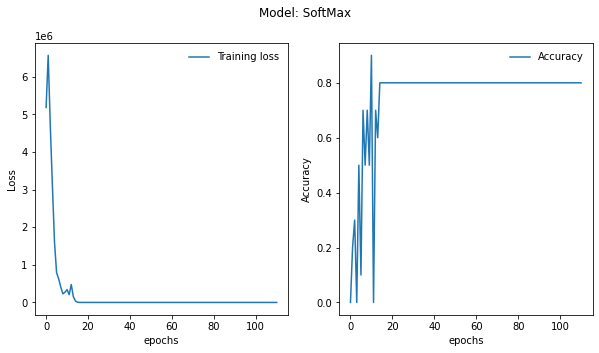

In [13]:
softmax = buildModel(SoftMax(), 0.1, True, True)

### Reconstruction attack

In [14]:
# values from paper with adjusted gamma and cost function
alpha = 5000
beta = 100
gamma = 0.1
delta = 0.1

# returns a vector with all costs for all labels
def my_cost(pred):
    cost = torch.ones(pred.shape) - pred
    return cost    

In [19]:
def invert(model, img, criterion, optimizer, lr, c, best_cost, best_x, i, b, beta, gamma):
    img = torch.Tensor(img).view(1, -1)
    if not img.requires_grad:
        img.requires_grad = True
        
    optimizer.zero_grad()
    pred = model(img)
    b -= 1

    
    # calculate cost
    cost = my_cost(F.softmax(pred))
    cost = cost.detach().numpy().flatten()[c]
    
    # calculate loss
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()  
    
    img = torch.clamp(img - lr * img.grad, 0, 255)
    np_a = np.array([np.clip(x + np.random.normal(2, 2),0,255) for x in img.detach().numpy()])
    
    if cost < best_cost:
        print("Cost was updated, is now", cost,"was", best_cost)
        best_cost = cost
        best_x = img.detach().numpy()
        b = beta
    
    if cost >= best_cost and b <= 0:
        print("Cost doesn't improve after", beta, "iterations with a best value of", best_cost)
        best_cost = cost
        best_x = img.detach().numpy()
        return best_cost, best_x, b, np_a.reshape(1, -1), True
    
    if cost <= gamma:
        print("Cost is lower than gamma with a value of ", cost)
        best_cost = cost
        best_x = img.detach().numpy()
        return best_cost, best_x, b, np_a.reshape(1, -1), True
    
    return best_cost, best_x, b, np_a.reshape(1, -1), False

<ipython-input-19-45fe293a0497>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cost = my_cost(F.softmax(pred))


Cost was updated, is now 0.9774466 was 1
Cost was updated, is now 0.0 was 0.9774466
Cost is lower than gamma with a value of  0.0


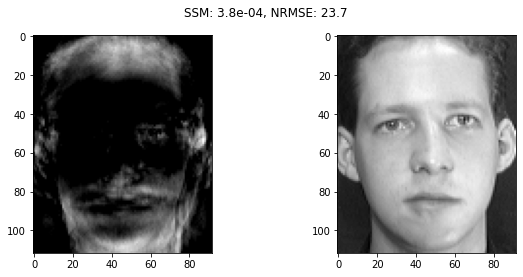

Cost was updated, is now 0.9748697 was 1
Cost was updated, is now 0.0 was 0.9748697
Cost is lower than gamma with a value of  0.0


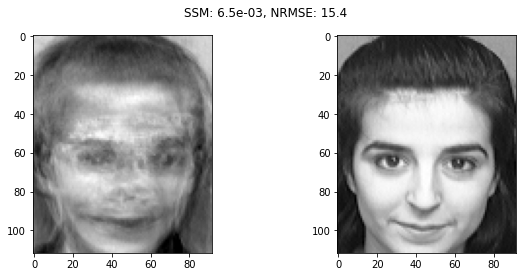

Cost was updated, is now 0.974962 was 1
Cost was updated, is now 0.0 was 0.974962
Cost is lower than gamma with a value of  0.0


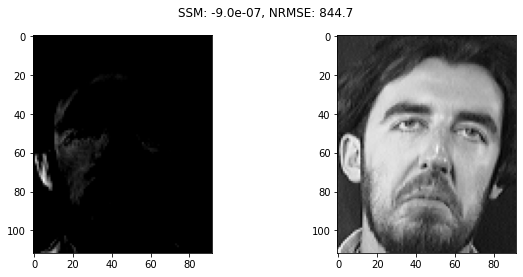

Cost was updated, is now 0.97514987 was 1
Cost was updated, is now 0.0 was 0.97514987
Cost is lower than gamma with a value of  0.0


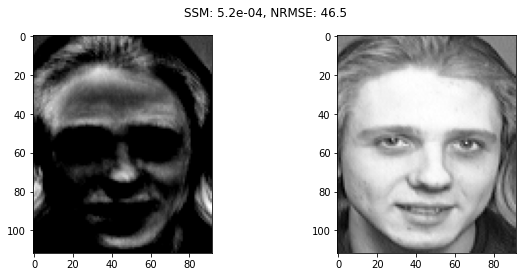

Cost was updated, is now 0.9760599 was 1
Cost was updated, is now 0.0 was 0.9760599
Cost is lower than gamma with a value of  0.0


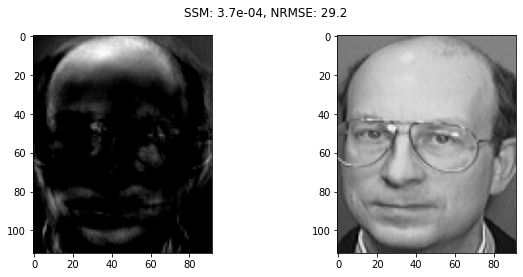

Cost was updated, is now 0.9743725 was 1
Cost was updated, is now 0.0 was 0.9743725
Cost is lower than gamma with a value of  0.0


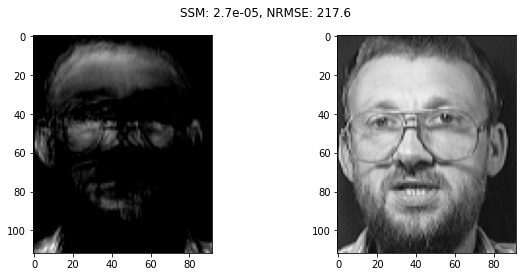

Cost was updated, is now 0.9745496 was 1
Cost was updated, is now 0.0 was 0.9745496
Cost is lower than gamma with a value of  0.0


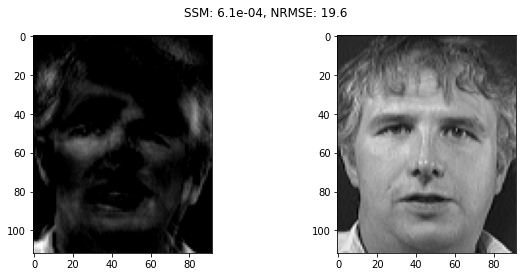

Cost was updated, is now 0.97576845 was 1
Cost was updated, is now 0.0 was 0.97576845
Cost is lower than gamma with a value of  0.0


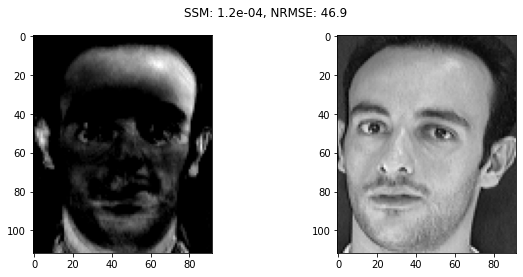

Cost was updated, is now 0.975336 was 1
Cost was updated, is now 0.0 was 0.975336
Cost is lower than gamma with a value of  0.0


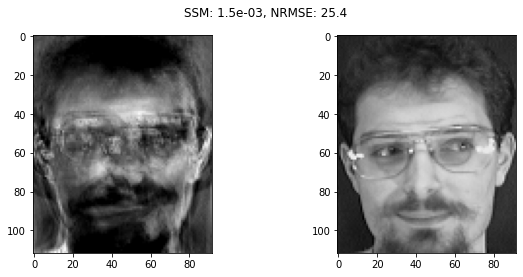

Cost was updated, is now 0.97716224 was 1
Cost was updated, is now 0.0 was 0.97716224
Cost is lower than gamma with a value of  0.0


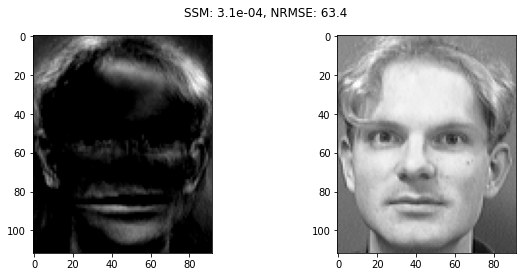

Cost was updated, is now 0.97618616 was 1
Cost was updated, is now 0.0 was 0.97618616
Cost is lower than gamma with a value of  0.0


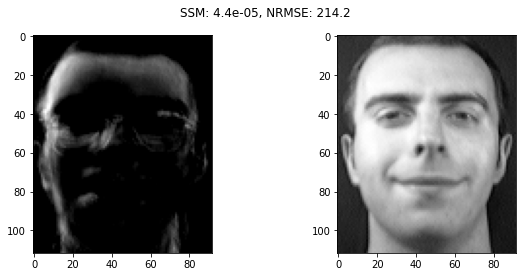

Cost was updated, is now 0.9747211 was 1
Cost was updated, is now 0.0 was 0.9747211
Cost is lower than gamma with a value of  0.0


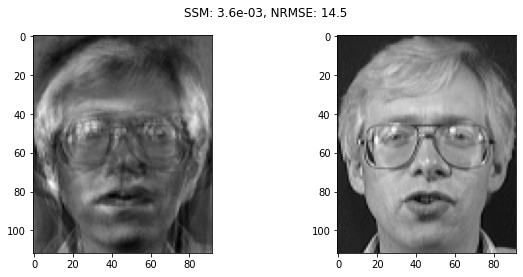

Cost was updated, is now 0.97450984 was 1
Cost was updated, is now 0.0 was 0.97450984
Cost is lower than gamma with a value of  0.0


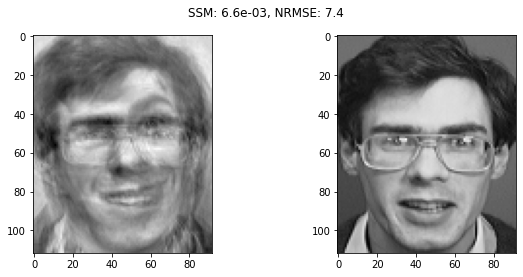

Cost was updated, is now 0.9734128 was 1
Cost was updated, is now 0.0 was 0.9734128
Cost is lower than gamma with a value of  0.0


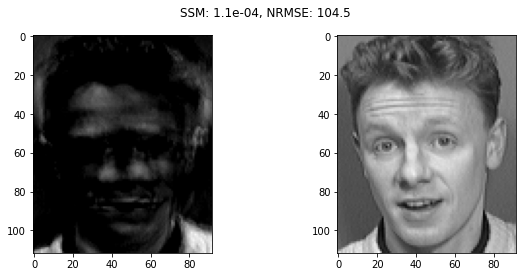

Cost was updated, is now 0.9718064 was 1
Cost was updated, is now 0.0 was 0.9718064
Cost is lower than gamma with a value of  0.0


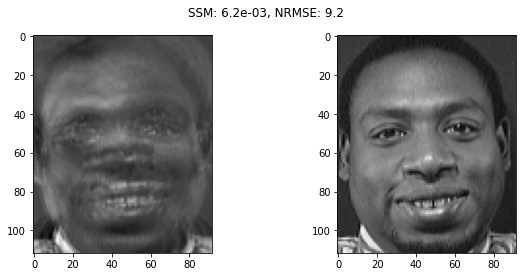

Cost was updated, is now 0.97470874 was 1
Cost was updated, is now 0.0 was 0.97470874
Cost is lower than gamma with a value of  0.0


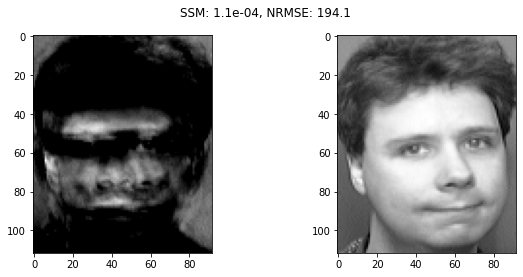

Cost was updated, is now 0.9743219 was 1
Cost was updated, is now 0.0 was 0.9743219
Cost is lower than gamma with a value of  0.0


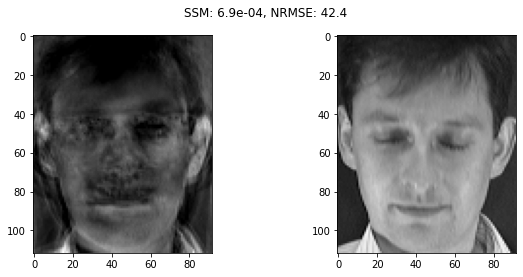

Cost was updated, is now 0.9763421 was 1
Cost was updated, is now 0.0 was 0.9763421
Cost is lower than gamma with a value of  0.0


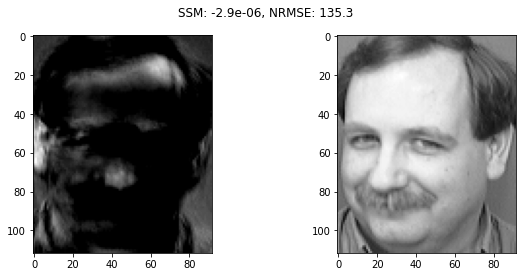

Cost was updated, is now 0.9761206 was 1
Cost was updated, is now 0.0 was 0.9761206
Cost is lower than gamma with a value of  0.0


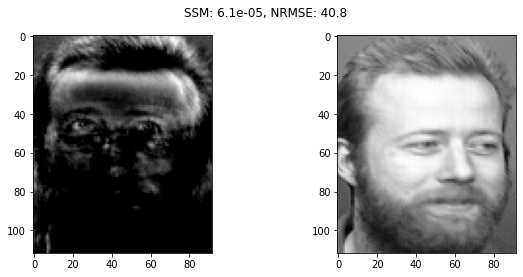

Cost was updated, is now 0.9749369 was 1
Cost was updated, is now 0.0 was 0.9749369
Cost is lower than gamma with a value of  0.0


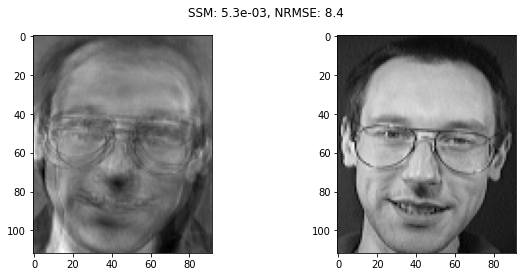

Cost was updated, is now 0.9748432 was 1
Cost was updated, is now 0.0 was 0.9748432
Cost is lower than gamma with a value of  0.0


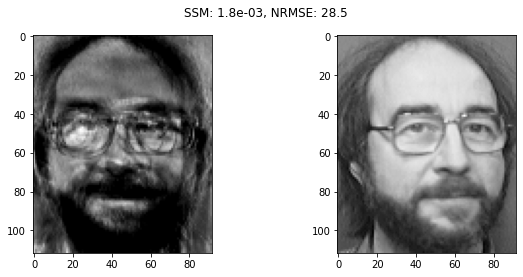

Cost was updated, is now 0.9722484 was 1
Cost was updated, is now 0.0 was 0.9722484
Cost is lower than gamma with a value of  0.0


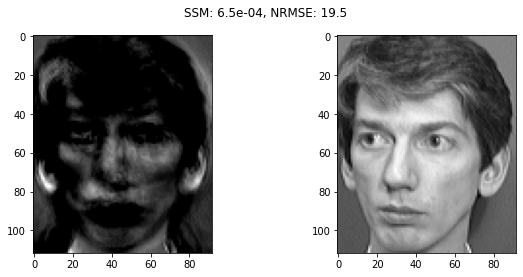

Cost was updated, is now 0.97465956 was 1
Cost was updated, is now 0.0 was 0.97465956
Cost is lower than gamma with a value of  0.0


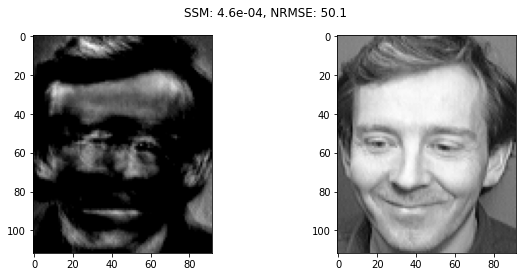

Cost was updated, is now 0.97391504 was 1
Cost was updated, is now 0.0 was 0.97391504
Cost is lower than gamma with a value of  0.0


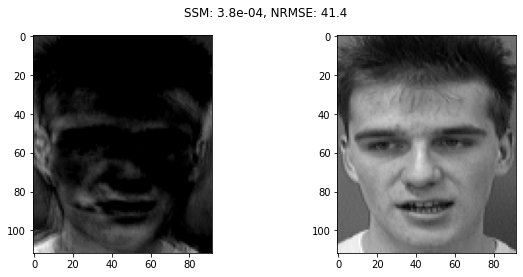

Cost was updated, is now 0.9738637 was 1
Cost was updated, is now 0.0 was 0.9738637
Cost is lower than gamma with a value of  0.0


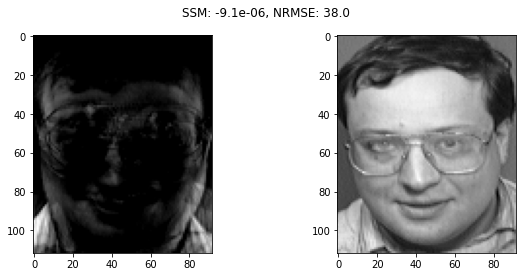

Cost was updated, is now 0.97634614 was 1
Cost was updated, is now 0.0 was 0.97634614
Cost is lower than gamma with a value of  0.0


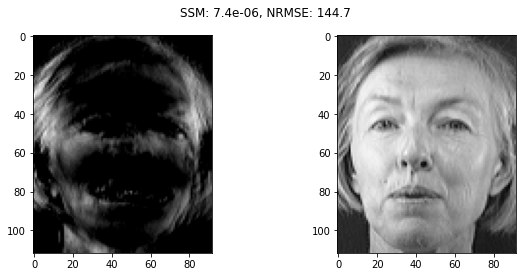

Cost was updated, is now 0.9732364 was 1
Cost was updated, is now 0.0 was 0.9732364
Cost is lower than gamma with a value of  0.0


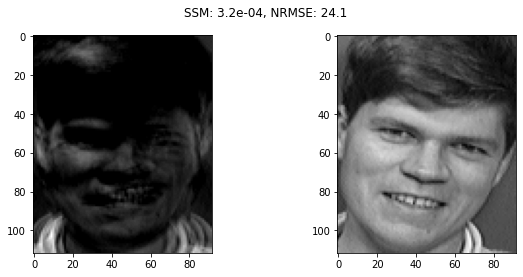

Cost was updated, is now 0.97361827 was 1
Cost was updated, is now 0.0 was 0.97361827
Cost is lower than gamma with a value of  0.0


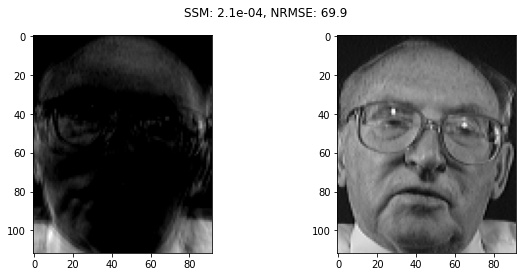

Cost was updated, is now 0.9753172 was 1
Cost was updated, is now 0.0 was 0.9753172
Cost is lower than gamma with a value of  0.0


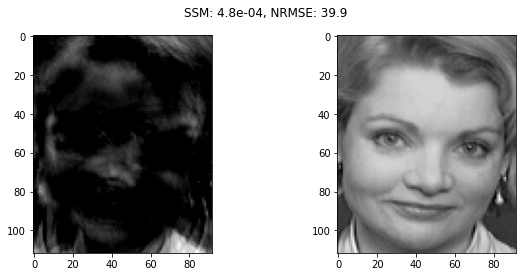

Cost was updated, is now 0.9747871 was 1
Cost was updated, is now 0.0 was 0.9747871
Cost is lower than gamma with a value of  0.0


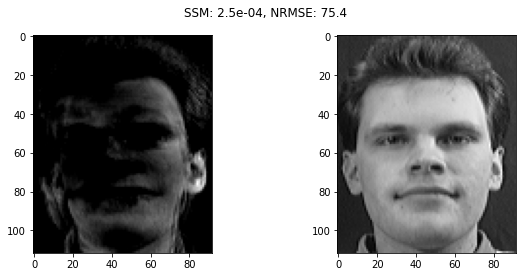

Cost was updated, is now 0.97425467 was 1
Cost was updated, is now 0.0 was 0.97425467
Cost is lower than gamma with a value of  0.0


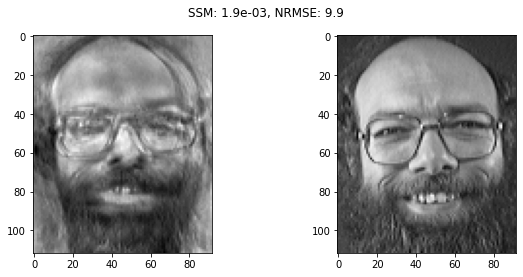

Cost was updated, is now 0.9752751 was 1
Cost was updated, is now 0.0 was 0.9752751
Cost is lower than gamma with a value of  0.0


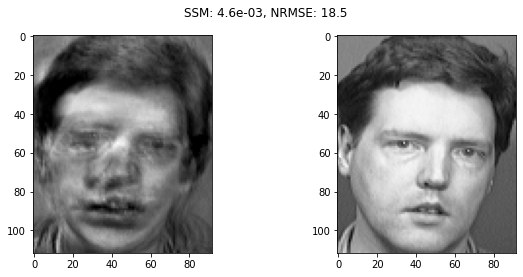

Cost was updated, is now 0.9726387 was 1
Cost was updated, is now 0.0 was 0.9726387
Cost is lower than gamma with a value of  0.0


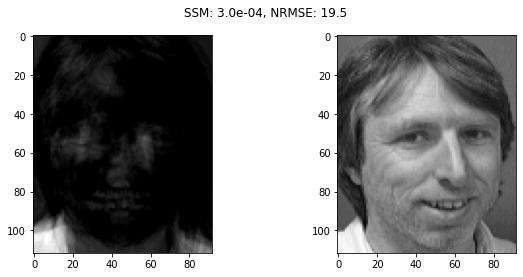

Cost was updated, is now 0.9758286 was 1
Cost was updated, is now 0.0 was 0.9758286
Cost is lower than gamma with a value of  0.0


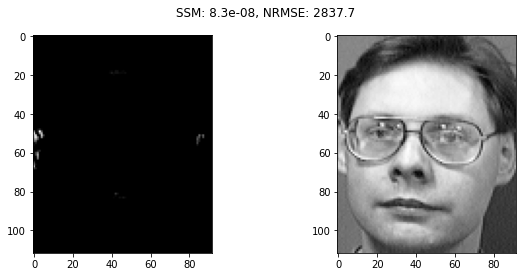

Cost was updated, is now 0.9757001 was 1
Cost was updated, is now 0.0 was 0.9757001
Cost is lower than gamma with a value of  0.0


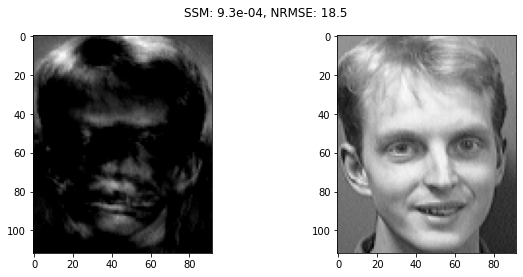

Cost was updated, is now 0.9768824 was 1
Cost was updated, is now 0.0 was 0.9768824
Cost is lower than gamma with a value of  0.0


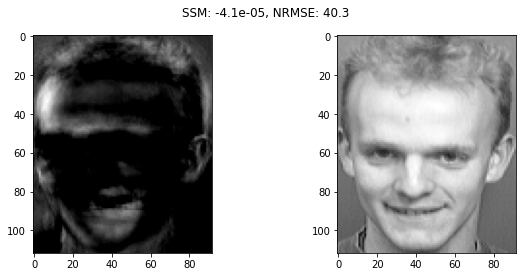

Cost was updated, is now 0.9774628 was 1
Cost was updated, is now 0.0 was 0.9774628
Cost is lower than gamma with a value of  0.0


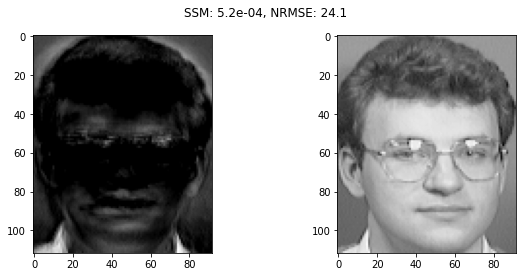

Cost was updated, is now 0.9754266 was 1
Cost was updated, is now 0.0 was 0.9754266
Cost is lower than gamma with a value of  0.0


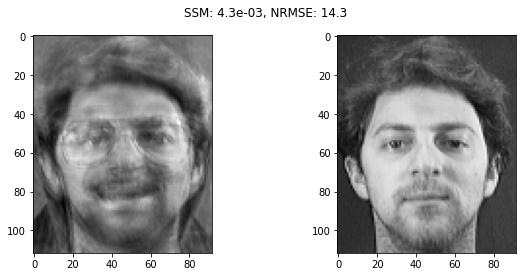

Cost was updated, is now 0.9758862 was 1
Cost was updated, is now 0.0 was 0.9758862
Cost is lower than gamma with a value of  0.0


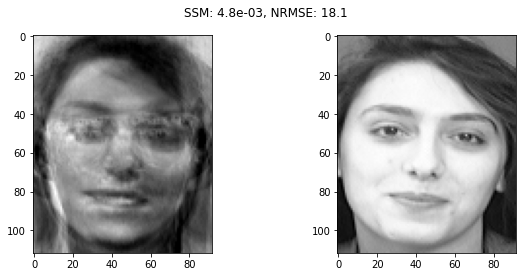

Cost was updated, is now 0.97506654 was 1
Cost was updated, is now 0.0 was 0.97506654
Cost is lower than gamma with a value of  0.0


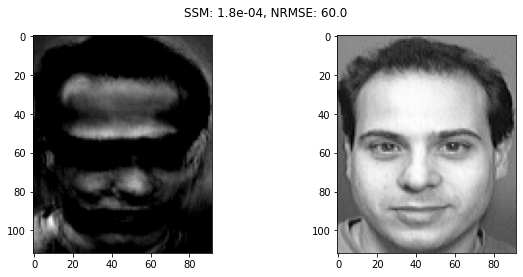

Duration in sec: 27


In [20]:
startTime = time.time()
timeStr = time.strftime("%H:%M:%S", time.localtime(startTime))
show = True
save = True
mse_all, nrmsev_all, ssmv_all, epochs = [],[],[],[]
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(softmax.parameters(), lr=delta)
test_x = get_orig()
rec_x = np.zeros((40,112,92), dtype='float32')

for c in classes:
    best_x,best_cost='',1
    img = np.zeros_like(test_x[0])
    b = beta
    for i in range(alpha):
        best_cost, best_x, b, img, stop = invert(softmax, img, criterion, optimizer, 
                                              delta, c_to_i(c), best_cost, best_x, i, 
                                              b, beta, gamma)
        if stop:
            epochs.append(i)
            break
    orig = test_x[c_to_i(c)]
    rec = best_x.reshape(112, 92)
    rec_x[c_to_i(c)] = rec
    ssmv = ssm(rec,orig)
    msev = mse(rec,orig)
    nrmsev = nrmse(rec,orig)
    mse_all.append(msev)
    nrmsev_all.append(nrmsev)
    ssmv_all.append(ssmv)
    
    if (show or save):
        fig = plt.figure(figsize=(10, 4))
        fig.suptitle("SSM: {:.1e}, NRMSE: {:.1f}".format(ssmv,nrmsev))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(rec, cmap='gray')
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(orig, cmap='gray')
        if save:
            plt.savefig(f'./data/results/class_{c}.png')
        if show:
            plt.show()
        
endTime = time.time()
dur = endTime - startTime
print("Duration in sec: " + str(int(dur)))

In [62]:
# Calculating means performance values of all images
print('MSE mean',np.mean(mse_all))
print('NRMSE mean',np.mean(nrmsev_all))
print('SSM mean',np.mean(ssmv_all))
print('Epochs mean',np.mean(epochs))

MSE mean 14551.60220939985
NRMSE mean 264.9349131754242
SSM mean 0.0016527008567844156
Epochs mean 1.325


0